This notebook does the following:
1. Load raw reddit submission data from dataframes scraped by `scripts/get_reddit_gamethreads.py`.
2. Add a couple of useful columns: `date` for the date that the game was played, and `is_postgame` indicating
whether the post is an in-game thread or post-game thread
3. Parse the title to extract the names of the two teams playing, in the form of team_ids as given in `data/teams.csv`.
4. Add a `gid` column, of the form `YYYY-mm-dd_team1ID_team2ID`, where `(team1ID,team2ID)` are the team_ids of the
two teams sorted in alphabetical order. This uniquely identifies each game.

In [1]:
import glob
import datetime as dt
import re
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import watchcbb.reddit_utils as ru

### Load gamethread dataframes from gzipped pickled files

In [2]:
dfs = []
for fname in glob.glob('../data/gamethreads/*/*.pkl.gz'):
    with open(fname, 'rb') as fid:
        df = pd.read_pickle(fid, compression='gzip')
    dfs.append(df)
df = pd.concat(dfs)
df = df[df.title.apply(lambda x: '[game' in x.lower() or '[post' in x.lower())].reset_index()
print(df.shape)
df.head()

(12853, 115)


,index,_reddit,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,...,is_video,_fetched,comment_limit,comment_sort,_comments_by_id,post_hint,preview,link_flair_template_id,crosspost_parent_list,crosspost_parent
0,0,<praw.reddit.Reddit object at 0x7ff9f137da50>,None,CollegeBasketball,[removed],t2_1j9zdlp,False,None,0,False,...,False,False,2048,confidence,{},NaN,NaN,NaN,NaN,NaN
1,1,<praw.reddit.Reddit object at 0x7ff9f137da50>,None,CollegeBasketball,[Box score](https://www.espn.com/mens-college-...,t2_eh5w6,False,None,0,False,...,False,False,2048,confidence,{},self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN
2,2,<praw.reddit.Reddit object at 0x7ff9f137da50>,None,CollegeBasketball,[Box Score](https://www.espn.com/mens-college-...,t2_1j9zdlp,False,None,0,False,...,False,False,2048,confidence,{},self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN
3,3,<praw.reddit.Reddit object at 0x7ff9f137da50>,None,CollegeBasketball,[Box Score](https://www.espn.com/mens-college-...,t2_1j9zdlp,False,None,0,False,...,False,False,2048,confidence,{},self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN
4,4,<praw.reddit.Reddit object at 0x7ff9f137da50>,None,CollegeBasketball,[Box Score](https://www.espn.com/mens-college-...,t2_1j9zdlp,False,None,0,False,...,False,False,2048,confidence,{},self,{'images': [{'source': {'url': 'https://extern...,NaN,NaN,NaN


### Add `timestamp`, `date`, and `is_postgame` columns

In [3]:
df["timestamp"] = df.created.apply(dt.datetime.fromtimestamp)  # UNIX epoch -> datetime (in UTC)
df["date"] = df.created.apply(ru.date_from_timestamp)  # Convert to date of game
df["is_postgame"] = df.title.apply(lambda x:"[post " in x.lower())  # in-game or post-game thread?
df = df.sort_values("timestamp").reset_index()
df[["timestamp","date","id","title","is_postgame","ups","num_comments"]].head(30)

,timestamp,date,id,title,is_postgame,ups,num_comments
0,2018-11-06 18:30:29,2018-11-06,9upt5k,[Game Thread] Wisconsin Lutheran @ Green Bay (...,False,24,25
1,2018-11-06 21:33:44,2018-11-06,9urjew,[Post Game Thread] (NCAAW) Gardner-Webb defeat...,True,42,7
2,2018-11-06 22:00:28,2018-11-06,9ursii,[Game Thread] St. Francis (PA) @ Buffalo (4:00...,False,5,3
3,2018-11-06 22:10:06,2018-11-06,9urvry,[Post Game Thread] Green Bay defeats Wisconsin...,True,17,9
4,2018-11-07 00:30:36,2018-11-06,9ut6vb,[Game Thread] Chicago State @ Indiana (6:30 PM...,False,32,114
5,2018-11-07 00:30:45,2018-11-06,9ut6xa,[Game Thread] Wagner @ Seton Hall (6:30 PM ET),False,3,7
6,2018-11-07 00:39:33,2018-11-06,9ut9t9,[Game Thread] Siena @ Providence (6:30 PM ET),False,3,21
7,2018-11-07 00:47:34,2018-11-06,9utcdt,[Game Thread] Loyola (MD) @ St. John's (6:30 P...,False,3,7
8,2018-11-07 00:53:24,2018-11-06,9ute5w,[Post Game Thread] Buffalo defeats St. Francis...,True,1,1
9,2018-11-07 01:00:44,2018-11-06,9utgf0,[Game Thread] #11 Michigan State @ #1 Kansas (...,False,111,1980


### Parse the titles into 2-tuples of team names

In [4]:
print((df.title.apply(ru.parse_title).isna()).sum())
df.title.apply(ru.parse_title).head(20)

298


0              [wisconsin-lutheran, green-bay]
1                      [gardner-webb, florida]
2                                         None
3              [green-bay, wisconsin-lutheran]
4                     [chicago-state, indiana]
5                         [wagner, seton-hall]
6                          [siena, providence]
7                                         None
8                    [buffalo, st.-francis-pa]
9                     [michigan-state, kansas]
10                          [towson, virginia]
11                   [lenoir-rhyne, tennessee]
12                   [north-carolina, wofford]
13                   [morgan-state, villanova]
14              [eastern-washington, syracuse]
15                      [the-citadel, clemson]
16                         [fairfield, purdue]
17    [south-carolina-upstate, south-carolina]
18                      [the-citadel, clemson]
19                         [fairfield, purdue]
Name: title, dtype: object

### Convert team names generated in above cell to team_ids
* These should match those stored in `data/teams.csv`.
* Replacements are made to fix some common errors
* A value of `None` is stored when we can't guess the corred ID
* The list outputted below shows the most common names that weren't able to be parsed

In [5]:
ru._BAD = []

df["team_ids"] = df.title.apply(ru.parse_title).apply(ru.fix_names)
print(df.team_ids.isna().sum())
pd.Series(ru._BAD).value_counts().head(20)

994


colorado-mines            10
boise-state-university     9
usc-upstate                9
fau                        9
sdsu                       7
odu                        7
mizzou                     7
                           6
ucsb                       6
chaminade                  6
pitt                       6
nc-a&t                     6
multnomah                  6
middle-tennessee-state     5
st.-francis-brooklyn       5
test                       5
westminster                5
saint-joseph’s             5
st.-joes                   5
nc-central                 5
dtype: int64

### Now generate a unique `gid` for each game
Format is `YYYY-mm-dd_teamID1_teamID2`, where `(teamID1,teamID2)` are sorted in alphabetical order

In [6]:
def get_gid(row):
    if row.team_ids is None:
        return None
    ids = sorted(row.team_ids)
    return f'{row.date}_{ids[0]}_{ids[1]}'

df["gid"] = df.apply(get_gid, axis=1)
tosave = df[["date","timestamp","id","gid","is_postgame","ups","num_comments","title"]].copy()
tosave.head(10)

,date,timestamp,id,gid,is_postgame,ups,num_comments,title
0,2018-11-06,2018-11-06 18:30:29,9upt5k,None,False,24,25,[Game Thread] Wisconsin Lutheran @ Green Bay (...
1,2018-11-06,2018-11-06 21:33:44,9urjew,2018-11-06_florida_gardner-webb,True,42,7,[Post Game Thread] (NCAAW) Gardner-Webb defeat...
2,2018-11-06,2018-11-06 22:00:28,9ursii,None,False,5,3,[Game Thread] St. Francis (PA) @ Buffalo (4:00...
3,2018-11-06,2018-11-06 22:10:06,9urvry,None,True,17,9,[Post Game Thread] Green Bay defeats Wisconsin...
4,2018-11-06,2018-11-07 00:30:36,9ut6vb,2018-11-06_chicago-state_indiana,False,32,114,[Game Thread] Chicago State @ Indiana (6:30 PM...
5,2018-11-06,2018-11-07 00:30:45,9ut6xa,2018-11-06_seton-hall_wagner,False,3,7,[Game Thread] Wagner @ Seton Hall (6:30 PM ET)
6,2018-11-06,2018-11-07 00:39:33,9ut9t9,2018-11-06_providence_siena,False,3,21,[Game Thread] Siena @ Providence (6:30 PM ET)
7,2018-11-06,2018-11-07 00:47:34,9utcdt,None,False,3,7,[Game Thread] Loyola (MD) @ St. John's (6:30 P...
8,2018-11-06,2018-11-07 00:53:24,9ute5w,2018-11-06_buffalo_saint-francis-pa,True,1,1,[Post Game Thread] Buffalo defeats St. Francis...
9,2018-11-06,2018-11-07 01:00:44,9utgf0,2018-11-06_kansas_michigan-state,False,111,1980,[Game Thread] #11 Michigan State @ #1 Kansas (...


### Some `gid`s are duplicated due to multiple/deleted posts. These are the ones with highest multiplicity.

In [7]:
tosave.gid.value_counts().head(10)

2019-12-07_arkansas-little-rock_north-texas    12
2018-11-24_louisiana-state_texas-am            10
2019-11-10_florida_florida-state                9
2020-02-19_indiana_minnesota                    9
2018-12-08_marquette_wisconsin                  9
2020-02-29_baylor_texas-christian               8
2019-03-17_michigan_michigan-state              8
2018-11-14_indiana_marquette                    8
2019-11-16_tennessee-martin_wichita-state       8
2020-01-23_indiana_michigan-state               7
Name: gid, dtype: int64

### We want to save only the one example of game/post-game thread with highest comment count
* First sort by `gid` and `is_postgame` to group into groups that we want to reduce
* Sort by `num_comments` and `ups`, and we will then keep only the last example of each group

In [8]:
tosave = tosave.sort_values(['gid','is_postgame','num_comments','ups'])
tosave[tosave.gid=='2019-11-10_florida_florida-state']

,date,timestamp,id,gid,is_postgame,ups,num_comments,title
6932,2019-11-10,2019-11-10 19:58:25,duer62,2019-11-10_florida_florida-state,False,1,0,[Game Thread] Florida State @ #6 Florida (1:00...
6931,2019-11-10,2019-11-10 19:58:23,duer5r,2019-11-10_florida_florida-state,False,38,312,[Game Thread] Florida State @ #6 Florida (1:00...
6946,2019-11-10,2019-11-10 22:14:42,dugox6,2019-11-10_florida_florida-state,True,1,0,[Post Game Thread] Florida State defeats #6 Fl...
6943,2019-11-10,2019-11-10 22:14:00,dugohg,2019-11-10_florida_florida-state,True,2,0,[Post Game Thread] Florida State defeats #6 Fl...
6948,2019-11-10,2019-11-10 22:30:44,dugx5q,2019-11-10_florida_florida-state,True,0,1,[Post Game Thread] Florida State defeats Flori...
6947,2019-11-10,2019-11-10 22:29:36,dugwlz,2019-11-10_florida_florida-state,True,1,1,[Post Game Thread] Florida State defeats Flori...
6944,2019-11-10,2019-11-10 22:14:04,dugoih,2019-11-10_florida_florida-state,True,1,2,[Post Game Thread] Florida State defeats #6 Fl...
6949,2019-11-10,2019-11-10 22:33:07,dugyd8,2019-11-10_florida_florida-state,True,2,2,[Post Game Thread] Florida State defeats #6 Fl...
6942,2019-11-10,2019-11-10 22:13:57,dugogq,2019-11-10_florida_florida-state,True,1011,240,[Post Game Thread] Florida State defeats #6 Fl...


### Now drop the unwanted duplicates (as well as `None` gid values)

In [9]:
print("Before drop duplicates", tosave.shape)
tosave = tosave.drop_duplicates(['gid','is_postgame'], keep='last')
print("Before dropna", tosave.shape)
tosave.dropna(axis=0, subset=['gid'],inplace=True)
print("After dropna", tosave.shape)
tosave[tosave.gid=='2019-11-10_florida_florida-state']

Before drop duplicates (12853, 8)
Before dropna (9381, 8)
After dropna (9379, 8)


,date,timestamp,id,gid,is_postgame,ups,num_comments,title
6931,2019-11-10,2019-11-10 19:58:23,duer5r,2019-11-10_florida_florida-state,False,38,312,[Game Thread] Florida State @ #6 Florida (1:00...
6942,2019-11-10,2019-11-10 22:13:57,dugogq,2019-11-10_florida_florida-state,True,1011,240,[Post Game Thread] Florida State defeats #6 Fl...


### Check that everything looks good, and save the cleaned dataframe to a pickled file

In [10]:
tosave[tosave.gid.apply(lambda x:"_purdue" in x)].head(20)

,date,timestamp,id,gid,is_postgame,ups,num_comments,title
16,2018-11-06,2018-11-07 01:01:15,9utgmk,2018-11-06_fairfield_purdue,False,18,145,[Game Thread] Fairfield @ #21 Purdue (7:00 PM ET)
68,2018-11-06,2018-11-07 04:10:12,9uv11j,2018-11-06_fairfield_purdue,True,54,26,[Post Game Thread] #21 Purdue defeats Fairfiel...
260,2018-11-10,2018-11-11 02:00:38,9vz7ut,2018-11-10_ball-state_purdue,False,23,145,[Game Thread] Ball State @ #21 Purdue (8:00 PM...
274,2018-11-10,2018-11-11 05:03:46,9w0hng,2018-11-10_ball-state_purdue,True,96,27,[Post Game Thread] #21 Purdue defeats Ball Sta...
503,2018-11-15,2018-11-15 23:00:32,9xf8fx,2018-11-15_appalachian-state_purdue,False,17,182,[Game Thread] #19 Purdue @ Appalachian State (...
508,2018-11-15,2018-11-16 01:56:16,9xgr83,2018-11-15_appalachian-state_purdue,True,93,34,[Post Game Thread] #19 Purdue defeats Appalach...
554,2018-11-16,2018-11-17 00:30:30,9xqxsx,2018-11-16_davidson_purdue,False,20,129,[Game Thread] #19 Purdue @ Davidson (6:30 PM ET)
579,2018-11-16,2018-11-17 03:53:19,9xsgw8,2018-11-16_davidson_purdue,True,126,25,[Post Game Thread] #19 Purdue defeats Davidson...
701,2018-11-18,2018-11-19 02:30:51,9ybjbu,2018-11-18_purdue_virginia-tech,False,81,1205,[Game Thread] #16 Virginia Tech @ #19 Purdue (...
721,2018-11-18,2018-11-19 05:39:29,9yd0sf,2018-11-18_purdue_virginia-tech,True,607,290,[Post Game Thread] #16 Virginia Tech defeats #...


In [11]:
with open('../data/gamethreads/aggregated_cleaned_2018-2020.pkl.gz', 'wb') as fid:
    tosave.to_pickle(fid, compression='gzip')

### Now make a couple of plots of #comments to make sure everything looks OK

[0.8438419592315621, 0]


Text(0, 0.5, 'Post-game')

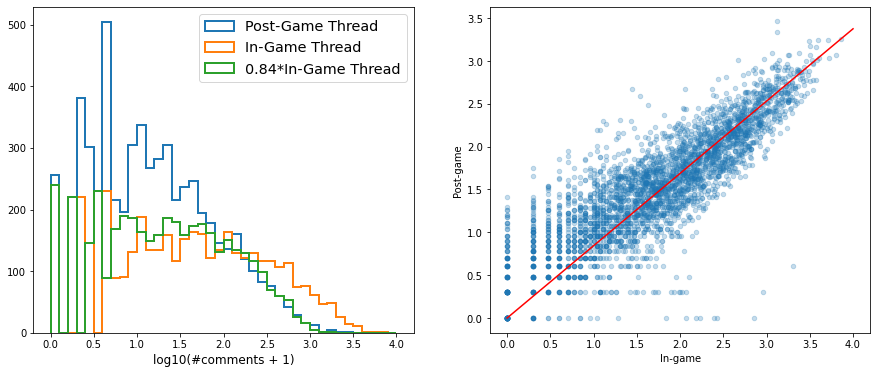

In [12]:
fig, axs = plt.subplots(1,2,figsize=(15,6))
axs[0].hist(np.log10(tosave.loc[df.is_postgame].num_comments.values+1), bins=np.linspace(0,4,41), histtype='step', lw=2, label="Post-Game Thread")
axs[0].hist(np.log10(tosave.loc[~df.is_postgame].num_comments.values+1), bins=np.linspace(0,4,41), histtype='step', lw=2, label="In-Game Thread")
axs[0].hist(0.844*np.log10(tosave.loc[~df.is_postgame].num_comments.values+1), bins=np.linspace(0,4,41), histtype='step', lw=2, label="0.84*In-Game Thread")
axs[0].legend(fontsize='x-large')
axs[0].set_xlabel("log10(#comments + 1)", fontsize='large')

xs = []
ys = []
for gid in tosave.gid.unique():
    mask1 = (tosave.gid==gid) & ~tosave.is_postgame
    mask2 = (tosave.gid==gid) & tosave.is_postgame
    if mask1.sum()!=1 or mask2.sum()!=1:
        continue
    xs.append(tosave.num_comments[mask1].values[0])
    ys.append(tosave.num_comments[mask2].values[0])
xs = np.log10(np.array(xs)+1)
ys = np.log10(np.array(ys)+1)
axs[1].scatter(xs, ys, s=20, alpha=0.25)
# p = np.polyfit(xs, ys, deg=1)
a = np.sum(xs*ys)/np.sum(xs*xs)
p = [a,0]
print(p)
axs[1].plot([0,4],p[0]*np.array([0,4])+p[1],'r-')
axs[1].set_xlabel('In-game')
axs[1].set_ylabel('Post-game')